# Problem Statement: To analyze the data and predict the status of the animals when they leave the welfare center

The Animal Welfare Center (AWC) is one of the oldest animal shelters in the United States that provide care and shelter to over 15,000 animals each year. To boost its effort to help and care for animals in need, the organization makes available its accumulated data and statistics as part of its Open Data Initiative. The data contains information about the intake and discharge of animals entering the Animal Welfare Center from the beginning of October 2013 to the present day.


The AWC wants to make use of this data to help uncover useful insights that have the potential to save these animals’ lives. To make better decisions in the future regarding animal safety, AWC wants to analyze this data and predict the status of the animals when they leave the welfare center.

**Problem Type**- Multiclass classification

**Chosen workflow Stage-**

1) Loading required libraries

2) Loading the data

3) Missing Value check

4) Quick EDA and data cleaning

5) Analyse, identify patterns, explore the data

6) Feature Engineering

7) Encoding the categorical data

8) Modelling, tuning and prediction(Multiple iterations and subject to changes)

9) Submission of results

** EVALUATION METRIC: f1-score**

**DATA PREPROCESSING**

# 1. Loading required libraries

I have used general libraries like pandas, malplotlib  for assembling, cleaning the data and most importantly libraries containing all the models

In [1]:
#LOADING REQUIRED LIBRARIES
#Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np

#Machine learning classification model libraries
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
%matplotlib inline


#Accuracy Check
from sklearn.model_selection import cross_val_score

#Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Scalers
from sklearn.preprocessing import StandardScaler

#Metrices import
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Importing train, test split library
from sklearn.model_selection import train_test_split

# Libraries to test model on different thresholds
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Metrices import
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from numpy import loadtxt
from numpy import sort

#Import warnings
import warnings
warnings.filterwarnings("ignore")

#Importing custom packages
from sklearn.base import TransformerMixin

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

** Defining some customer functions for specific use**

In [205]:
#Imputing the remaining missing variables
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, A, b=None):

        self.fill = pd.Series([A[c].value_counts().index[0]
            if A[c].dtype == np.dtype('O') else A[c].mean() for c in A],
            index=A.columns)

        return self

    def transform(self, A, b=None):
        return A.fillna(self.fill)

# 2. Loading the dataset

Lets have a quick look at the dataset:

In [234]:
ml_dataset_train= pd.read_csv('/Users/apple/Downloads/Animal State Prediction - dataset/train.csv')
ml_dataset_test= pd.read_csv('/Users/apple/Documents/Animal_State_Prediction_dataset/test.csv')

Text(0,0.5,'Frequency')

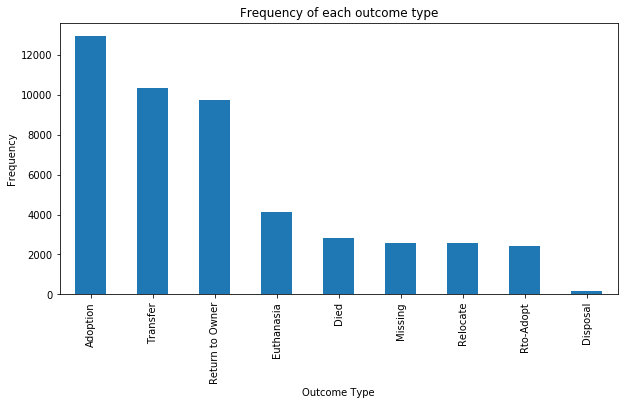

In [235]:
#Drawing a count plot of dependent variable to check the biasness of prediction in data present
ax = ml_dataset_train['outcome_type'].value_counts().plot(kind='bar',figsize=(10,5),title="Frequency of each outcome type")
ax.set_xlabel("Outcome Type")
ax.set_ylabel("Frequency")

In [236]:
print("Percent Class Distribution")
print(ml_dataset_train['outcome_type'].value_counts(normalize= True)*100)

Percent Class Distribution
Adoption           27.125913
Transfer           21.640901
Return to Owner    20.329268
Euthanasia          8.668912
Died                5.918039
Missing             5.436897
Relocate            5.382507
Rto-Adopt           5.125201
Disposal            0.372362
Name: outcome_type, dtype: float64


Data is highly biased. We need to select our train and test split carefully.

In [237]:
#Loading the dataset
X= pd.read_csv('/Users/apple/Documents/Animal_State_Prediction_dataset/train.csv')

# 3. Missing Value Check

In [238]:
#Missing data check
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent * 100], axis=1, keys=['Total', 'Percent(%)'])
missing_data.head(5)

,Total,Percent(%)
outcome_datetime,9619,20.122168
sex_upon_intake,1,0.002092
sex_upon_outcome,1,0.002092
outcome_type,0,0.000000
intake_type,0,0.000000


Hence we will be dropping outcome_datetime as more than 15% that i selected as a threshold is missing.

** "outcome_datetime" needs to be dropped remaining two missing values we can impute**

In [239]:
X = X.drop(['outcome_datetime'], axis  = 1)

In [240]:
X = DataFrameImputer().fit_transform(pd.DataFrame(X))

In [241]:
print('Missing value in training set:', X.isnull().sum().max())

Missing value in training set: 0


# 4. Quick EDA and data cleaning

**Description of Numeric variable:**

In [242]:
display(X.describe())

,dob_year,dob_month,count,age_upon_intake_(days),age_upon_intake_(years),intake_month,intake_year,intake_hour,intake_number,time_in_shelter_days,age_upon_outcome_(days),age_upon_outcome_(years),outcome_month,outcome_year,outcome_hour,outcome_number
count,47803.000000,47803.000000,47803.0,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000
mean,2012.197728,6.337531,1.0,841.679915,2.305972,6.596113,2014.600046,13.549087,1.144552,17.143366,855.319729,2.343342,6.650587,2014.638893,14.381545,1.144552
std,3.068255,3.342038,0.0,1100.557953,3.015227,3.460172,0.905731,3.179397,0.500055,46.600727,1103.598596,3.023558,3.490263,0.912706,3.456145,0.500055
min,1992.000000,1.000000,1.0,0.000000,0.000000,1.000000,2013.000000,0.000000,1.000000,0.000694,0.000000,0.000000,1.000000,2013.000000,0.000000,1.000000
25%,2011.000000,4.000000,1.0,60.000000,0.164384,4.000000,2014.000000,11.000000,1.000000,1.049653,90.000000,0.246575,4.000000,2014.000000,12.000000,1.000000
50%,2013.000000,6.000000,1.0,365.000000,1.000000,7.000000,2015.000000,13.000000,1.000000,4.972222,365.000000,1.000000,7.000000,2015.000000,15.000000,1.000000
75%,2014.000000,9.000000,1.0,1095.000000,3.000000,10.000000,2015.000000,16.000000,1.000000,13.113889,1095.000000,3.000000,10.000000,2015.000000,17.000000,1.000000
max,2016.000000,12.000000,1.0,8030.000000,22.000000,12.000000,2018.000000,23.000000,13.000000,1606.194444,8030.000000,22.000000,12.000000,2018.000000,23.000000,13.000000


Couple of quick observations:

1. The variable **"count"** is having std 0 and min and max 1, implies it is a constant column having digit 1 hence we will be **dropping** this variable.

2. Also the statistics of **"intake_number"** and **"outcome_number"** looks similar hence lets quickly check and take a call.

In [243]:
qck_check= pd.DataFrame(X.groupby(['intake_number', 'outcome_number']).size())
display(qck_check)

,,0
intake_number,outcome_number,
1.0,1.0,42691
2.0,2.0,3956
3.0,3.0,789
4.0,4.0,226
5.0,5.0,80
6.0,6.0,32
7.0,7.0,12
8.0,8.0,6
9.0,9.0,3


This implies **"intake_number"** and **"outcome_number"** are **duplicate columns** hence we will **drop** anyone of the variable, **lets drop "outcome_number"** .

Applying quick eda observations i.e. to drop outcome_number and count column:

In [244]:
X = X.drop(['count', 'outcome_number'], axis = 1)
X.shape

(47803, 34)

**Description of Categorical variable**:

In [245]:
X.describe(include = ['O'])

,animal_id_outcome,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_age_group,intake_datetime,intake_monthyear,intake_weekday,time_in_shelter,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_age_group,outcome_monthyear,outcome_weekday,outcome_type
count,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803,47803
unique,42679,45,4,1847,443,8,5,5,9,34456,54,7,21083,45,4958,5,9,55,7,9
top,A721033,1 year,Dog,Domestic Shorthair Mix,Black/White,Normal,Stray,Intact Male,"(-0.025, 2.5]",2014-07-09 12:58:00,2015-06,Saturday,0 days 00:13:00.000000000,1 year,2014-05-05 00:00:00,Neutered Male,"(-0.025, 2.5]",2014-07,Saturday,Adoption
freq,13,8014,28222,13339,4975,41885,33345,14665,34049,63,2188,7371,56,8100,102,17560,33895,2072,7628,12967


In [246]:
X[X['animal_id_outcome']=='A721033']

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type
46278,A721033,2015,5,2 years,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Stray,Neutered Male,730,2.000000,"(-0.025, 2.5]",2018-03-14 10:57:00,3,2018,2018-03,Wednesday,10,1.0,2 days 05:07:00.000000000,2.213194,2 years,2015-05-20 00:00:00,Neutered Male,730,2.000000,"(-0.025, 2.5]",3,2018,2018-03,Friday,16,Return to Owner
46279,A721033,2015,5,1 year,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,365,1.000000,"(-0.025, 2.5]",2016-10-20 22:47:00,10,2016,2016-10,Thursday,22,10.0,0 days 20:08:00.000000000,0.838889,1 year,2015-05-20 00:00:00,Neutered Male,365,1.000000,"(-0.025, 2.5]",10,2016,2016-10,Friday,18,Return to Owner
46280,A721033,2015,5,1 year,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,365,1.000000,"(-0.025, 2.5]",2016-09-03 14:30:00,9,2016,2016-09,Saturday,14,11.0,8 days 23:10:00.000000000,8.965278,1 year,2015-05-20 00:00:00,Neutered Male,365,1.000000,"(-0.025, 2.5]",9,2016,2016-09,Monday,13,Return to Owner
46281,A721033,2015,5,1 year,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Stray,Neutered Male,365,1.000000,"(-0.025, 2.5]",2016-07-10 11:53:00,7,2016,2016-07,Sunday,11,12.0,1 days 05:51:00.000000000,1.243750,1 year,2015-05-20 00:00:00,Neutered Male,365,1.000000,"(-0.025, 2.5]",7,2016,2016-07,Monday,17,Return to Owner
46282,A721033,2015,5,9 months,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Stray,Neutered Male,270,0.739726,"(-0.025, 2.5]",2016-02-20 10:44:00,2,2016,2016-02,Saturday,10,13.0,0 days 05:34:00.000000000,0.231944,9 months,2015-05-20 00:00:00,Neutered Male,270,0.739726,"(-0.025, 2.5]",2,2016,2016-02,Saturday,16,Return to Owner
46283,A721033,2015,5,2 years,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,730,2.000000,"(-0.025, 2.5]",2018-03-07 08:27:00,3,2018,2018-03,Wednesday,8,2.0,1 days 06:37:00.000000000,1.275694,2 years,2015-05-20 00:00:00,Neutered Male,730,2.000000,"(-0.025, 2.5]",3,2018,2018-03,Thursday,15,Return to Owner
46284,A721033,2015,5,2 years,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,730,2.000000,"(-0.025, 2.5]",2018-02-22 10:28:00,2,2018,2018-02,Thursday,10,3.0,1 days 02:38:00.000000000,1.109722,2 years,2015-05-20 00:00:00,Neutered Male,730,2.000000,"(-0.025, 2.5]",2,2018,2018-02,Friday,13,Return to Owner
46285,A721033,2015,5,1 year,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,365,1.000000,"(-0.025, 2.5]",2017-03-15 09:24:00,3,2017,2017-03,Wednesday,9,4.0,1 days 03:26:00.000000000,1.143056,1 year,2015-05-20 00:00:00,Neutered Male,365,1.000000,"(-0.025, 2.5]",3,2017,2017-03,Thursday,12,Return to Owner
46286,A721033,2015,5,1 year,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,365,1.000000,"(-0.025, 2.5]",2017-02-06 10:13:00,2,2017,2017-02,Monday,10,5.0,1 days 07:13:00.000000000,1.300694,1 year,2015-05-20 00:00:00,Neutered Male,365,1.000000,"(-0.025, 2.5]",2,2017,2017-02,Tuesday,17,Return to Owner
46287,A721033,2015,5,1 year,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,Normal,Public Assist,Neutered Male,365,1.000000,"(-0.025, 2.5]",2017-01-30 23:05:00,1,2017,2017-01,Monday,23,6.0,2 days 12:14:00.000000000,2.509722,1 year,2015-05-20 00:00:00,Neutered Male,365,1.000000,"(-0.025, 2.5]",2,2017,2017-02,Thursday,11,Return to Owner


Looking at the above dataset it looks like **"animal_id_outcome"** is not unique. Maybe same animals were repeated brought to the shelter for some or the other reasons. Anyways we will be dropping it as it makes very little or no help in our model predictions.

In [247]:
X = X.drop(['animal_id_outcome'], axis = 1)

# 5. Analyse, identify patterns, explore the data

Next step would be to analyse, identify and explore the data to take actions based upon the understanding.

**A. Few quick points to be noted:**
1. age_upon_intake_(days), age_upon_intake_(years)/age_group are extracted from age_upon_intake and there is no point using all of them. Hence we will keep age_upon_intake_(days) as it is more specific. Hence **dropping age_upon_intake**, **age_upon_intake_(years), age_upon_intake_age_group** similary **dropping age_upon_outcome, age_upon_outcome_(years), age_upon_outcome_age_group

2. dob_year, dob_month is extracted from date_of_birth hence will be using dob_year to be more specific and ** dropping date_of_birth ** and **dob_month**  as they are useless for our case.
3. According to my research once the animal or pet is surrendender by owner the animal/pet cannot be or vary rarely returned back to owner again with some conditions hence **intake_type** is an **important predictor**.
4. animal_type and breed type is specific to the category of animal hence are correlated. We need to take a call whether to use both or use one of them according to the varibale importance curve
5. time_in_shelter_(days) is derived from time_in_shelter hence will be **dropping time_in_shelter** and keeping **time_in_shelter_(days)**


In [248]:
X = X.drop(['age_upon_intake', 'age_upon_intake_(years)', 'age_upon_intake_age_group', 'age_upon_outcome', 'age_upon_outcome_(years)', 'age_upon_outcome_age_group', 'date_of_birth','dob_month', 'time_in_shelter'], axis = 1)

**B. Checking categorical variables correlation with outcome_type **

In [249]:
#Checking animal_type with outcome_type
X.groupby(["animal_type", 'outcome_type']).size()

animal_type  outcome_type   
Bird         Adoption             49
             Died                 13
             Disposal             17
             Euthanasia           32
             Missing               7
             Relocate             11
             Return to Owner       2
             Rto-Adopt             7
             Transfer             34
Cat          Adoption           4679
             Died               1279
             Disposal              2
             Euthanasia         1009
             Missing            1124
             Relocate           1136
             Return to Owner     896
             Rto-Adopt          1049
             Transfer           5777
Dog          Adoption           8211
             Died               1443
             Disposal              3
             Euthanasia         1305
             Missing            1433
             Relocate           1386
             Return to Owner    8802
             Rto-Adopt          1363
         

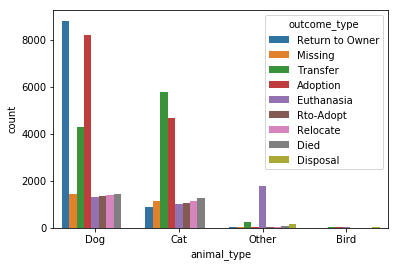

In [250]:
sns.countplot(x="animal_type", hue="outcome_type", data= X)

In [251]:
X_Bird = X[X['animal_type']=='Bird']

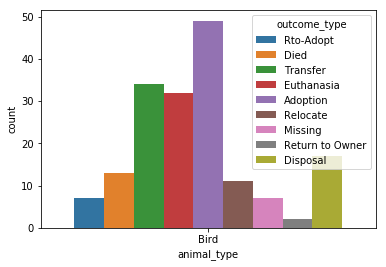

In [252]:
sns.countplot(x= 'animal_type', hue="outcome_type", data= X_Bird)

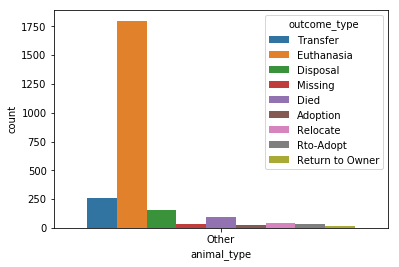

In [253]:
X_Other= X[X['animal_type']=='Other']
sns.countplot(x= 'animal_type', hue="outcome_type", data= X_Other)

In [254]:
#Checking animal_type with outcome_type
X.groupby(["breed", 'outcome_type']).size().head(20)

breed                                 outcome_type   
Abyssinian Mix                        Adoption           2
                                      Died               1
                                      Relocate           1
Affenpinscher Mix                     Adoption           2
                                      Died               1
                                      Missing            1
                                      Return to Owner    2
Afghan Hound Mix                      Return to Owner    1
Airedale Terrier                      Transfer           1
Airedale Terrier Mix                  Adoption           1
                                      Missing            1
                                      Return to Owner    4
                                      Transfer           1
Airedale Terrier/Irish Terrier        Relocate           1
Airedale Terrier/Labrador Retriever   Missing            1
                                      Transfer           1
Ai

Hence we get this insights that dogs are mostly adopted and returned back to owner, cats are either mostly been adopted or transfered, on the other hand bird are either adopted or transfered and are rarely "returned back to owner"(which has high occurence in the dataset). Last other animals are mostly euthonised or transfered.

**NOTE** We will be holding color variable as it is as there more than 400 unique colors and will be checking later by variable importance plot.

In [255]:
#Checking intake-condition 
X.groupby(['intake_type','outcome_type']).size()

intake_type         outcome_type   
Euthanasia Request  Adoption             12
                    Died                  7
                    Euthanasia          189
                    Missing               3
                    Relocate              1
                    Return to Owner       5
                    Rto-Adopt             1
                    Transfer             17
Owner Surrender     Adoption           3460
                    Died                644
                    Disposal              2
                    Euthanasia          506
                    Missing             649
                    Relocate            610
                    Return to Owner     562
                    Rto-Adopt           588
                    Transfer           2089
Public Assist       Adoption            274
                    Died                 58
                    Disposal             20
                    Euthanasia          193
                    Missing             

Hence this along with intake_condition can be useful for model to help predict minority of the dependent variable such as died, disposal, missing and relocate hence our hypothesis of these variable to be important for model is proving true.

In [256]:
X.groupby(['sex_upon_intake','sex_upon_outcome', 'outcome_type']).size()

sex_upon_intake  sex_upon_outcome  outcome_type   
Intact Female    Intact Female     Adoption            235
                                   Died                361
                                   Disposal              1
                                   Euthanasia          616
                                   Missing             324
                                   Relocate            324
                                   Return to Owner     549
                                   Rto-Adopt           318
                                   Transfer           2650
                 Spayed Female     Adoption           4254
                                   Died                554
                                   Euthanasia           43
                                   Missing             597
                                   Relocate            584
                                   Return to Owner     691
                                   Rto-Adopt           536
     

Hence we will be keeping on i.e for now as we can clearly see Intact male/female who were first intact and later neutered/spayed have more chances of adoption about 20 folds. hence this can prove to be an important variable.

One more observation is that we will be dropping intake_datetime as we already have intake month, year

In [257]:
X['intake_day'] = pd.DatetimeIndex(X['intake_datetime']).day

**Note: The above is a new feature that is generated**

In [258]:
X = X.drop(['intake_datetime'], axis = 1)

**Feature modification of intake/outcome year month:**

In [259]:
X['intake_monthyear'] = X['intake_year'] * 100 + X['intake_month']
X['outcome_monthyear'] = X['outcome_year']* 100 + X['outcome_month']
X

,dob_year,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(days),outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type,intake_day
0,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,3650,12,2017,201712,Thursday,14,1.0,0.588194,Neutered Male,3650,12,2017,201712,Thursday,0,Return to Owner,7
1,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2555,12,2014,201412,Friday,10,2.0,1.259722,Neutered Male,2555,12,2014,201412,Saturday,16,Return to Owner,19
2,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2190,3,2014,201403,Friday,14,3.0,1.113889,Neutered Male,2190,3,2014,201403,Saturday,17,Return to Owner,7
3,2004,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,3650,4,2014,201404,Wednesday,15,1.0,4.970139,Neutered Male,3650,4,2014,201404,Monday,15,Missing,2
4,1997,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,5840,11,2013,201311,Saturday,9,1.0,0.119444,Neutered Male,5840,11,2013,201311,Saturday,11,Return to Owner,16
5,1998,Dog,Labrador Retriever/Pit Bull,Black/White,Aged,Stray,Spayed Female,5475,11,2013,201311,Saturday,14,1.0,0.870833,Spayed Female,5475,11,2013,201311,Sunday,11,Return to Owner,16
6,1999,Dog,Miniature Schnauzer Mix,Black/Gray,Normal,Stray,Intact Female,5475,11,2014,201411,Friday,15,1.0,0.178472,Intact Female,5475,11,2014,201411,Friday,19,Return to Owner,14
7,1999,Dog,Lhasa Apso Mix,Brown/White,Normal,Stray,Neutered Male,5475,9,2014,201409,Monday,11,1.0,0.213194,Neutered Male,5475,9,2014,201409,Monday,16,Return to Owner,15
8,1999,Dog,Shetland Sheepdog Mix,White/Black,Normal,Public Assist,Neutered Male,5475,3,2014,201403,Monday,9,1.0,6.258333,Neutered Male,5475,3,2014,201403,Sunday,15,Return to Owner,17
9,1997,Dog,Shetland Sheepdog Mix,Brown/White,Normal,Stray,Spayed Female,6570,9,2015,201509,Friday,17,1.0,0.054167,Spayed Female,6570,9,2015,201509,Friday,19,Return to Owner,18


My hypothesis regarding outcomeWeekdays should be that there will more adoptions on sundays and saturdays as people have holiday and they can visit the facility for official adoption. I dont think that intakeWeekdays will have much significance to our prediction, we will check and discard it later if required.

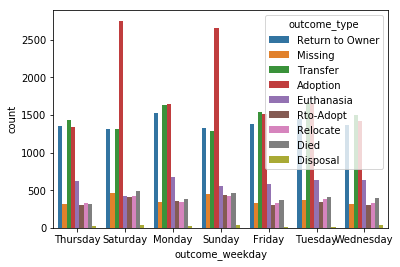

In [260]:
sns.countplot(x= 'outcome_weekday', hue="outcome_type", data= X)

The results are as expected there are relatively more adoptions on saturday and sundays. Hence we will keep these variables for now and test it in our variable importance plot.

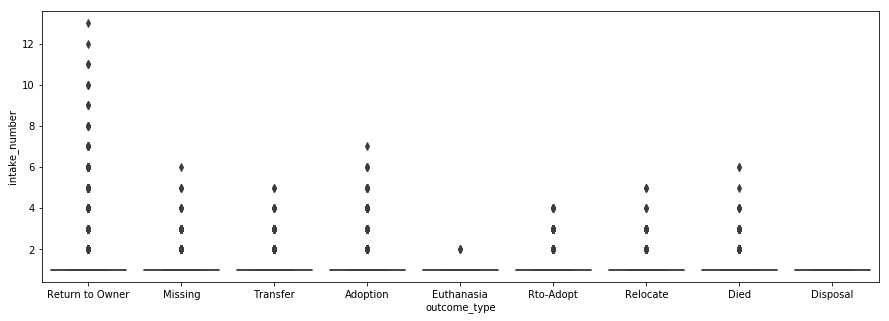

In [261]:
pyplot.figure(figsize=(15,5))
sns.boxplot(X['outcome_type'], X['intake_number'])

Higher number of intake_number has more chances of returning to owner, adoption and missing. Hence an important variable

Lets have a quick check on variable importance and model performance so that we can tweak it accordingly.

** Converting the data into training and validation set **

In [262]:
X

,dob_year,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(days),outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type,intake_day
0,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,3650,12,2017,201712,Thursday,14,1.0,0.588194,Neutered Male,3650,12,2017,201712,Thursday,0,Return to Owner,7
1,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2555,12,2014,201412,Friday,10,2.0,1.259722,Neutered Male,2555,12,2014,201412,Saturday,16,Return to Owner,19
2,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2190,3,2014,201403,Friday,14,3.0,1.113889,Neutered Male,2190,3,2014,201403,Saturday,17,Return to Owner,7
3,2004,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,3650,4,2014,201404,Wednesday,15,1.0,4.970139,Neutered Male,3650,4,2014,201404,Monday,15,Missing,2
4,1997,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,5840,11,2013,201311,Saturday,9,1.0,0.119444,Neutered Male,5840,11,2013,201311,Saturday,11,Return to Owner,16
5,1998,Dog,Labrador Retriever/Pit Bull,Black/White,Aged,Stray,Spayed Female,5475,11,2013,201311,Saturday,14,1.0,0.870833,Spayed Female,5475,11,2013,201311,Sunday,11,Return to Owner,16
6,1999,Dog,Miniature Schnauzer Mix,Black/Gray,Normal,Stray,Intact Female,5475,11,2014,201411,Friday,15,1.0,0.178472,Intact Female,5475,11,2014,201411,Friday,19,Return to Owner,14
7,1999,Dog,Lhasa Apso Mix,Brown/White,Normal,Stray,Neutered Male,5475,9,2014,201409,Monday,11,1.0,0.213194,Neutered Male,5475,9,2014,201409,Monday,16,Return to Owner,15
8,1999,Dog,Shetland Sheepdog Mix,White/Black,Normal,Public Assist,Neutered Male,5475,3,2014,201403,Monday,9,1.0,6.258333,Neutered Male,5475,3,2014,201403,Sunday,15,Return to Owner,17
9,1997,Dog,Shetland Sheepdog Mix,Brown/White,Normal,Stray,Spayed Female,6570,9,2015,201509,Friday,17,1.0,0.054167,Spayed Female,6570,9,2015,201509,Friday,19,Return to Owner,18


# Feature encoding(initial iteration)

In [263]:
X_check = X.copy()

In [264]:
def onehotdataframe(X_check):    
    one_hot_animal_type=pd.get_dummies(X_check.animal_type)

    one_hot_intake_condition = pd.get_dummies(X_check.intake_condition)
    one_hot_intake_condition.columns = [str(col) + '_intake' for col in one_hot_intake_condition.columns]

    one_hot_intake_type = pd.get_dummies(X_check.intake_type)
    one_hot_intake_type.columns = [str(col) + '_intake' for col in one_hot_intake_type.columns]

    one_hot_sex_upon_intake = pd.get_dummies(X_check.sex_upon_intake)
    one_hot_sex_upon_intake.columns = [str(col) + '_intake' for col in one_hot_sex_upon_intake.columns]

    one_hot_intake_weekday = pd.get_dummies(X_check.intake_weekday)
    one_hot_intake_weekday.columns = [str(col) + '_intake' for col in one_hot_intake_weekday.columns]

    one_hot_sex_upon_outcome = pd.get_dummies(X_check.sex_upon_outcome)
    one_hot_sex_upon_outcome.columns = [str(col) + '_outcome' for col in one_hot_sex_upon_outcome.columns]

    one_hot_outcome_weekday = pd.get_dummies(X_check.outcome_weekday)
    one_hot_outcome_weekday.columns = [str(col) + '_outcome' for col in one_hot_outcome_weekday.columns]     

    X_check = X_check.drop(['animal_type','intake_type', 'intake_condition', 'sex_upon_intake', 'intake_weekday', 'sex_upon_outcome', 'outcome_weekday'], axis = 1) 

    #Merging one hot encoded features with our dataset 'data' 
    X_check=pd.concat([X_check, one_hot_animal_type,one_hot_intake_condition,one_hot_intake_type,one_hot_sex_upon_intake,one_hot_intake_weekday,one_hot_sex_upon_outcome,one_hot_outcome_weekday],axis=1)  
    
    return(X_check)

In [265]:
X_check = onehotdataframe(X_check)
X_check['outcome_type'] = X_check['outcome_type'].map({'Adoption' : 8, 'Transfer': 7, 'Return to Owner' : 6, 'Euthanasia' : 5, 'Died' : 4, 'Missing' : 3, 'Relocate' : 2, 'Rto-Adopt' : 1, 'Disposal' : 0}) 
y_check = X_check['outcome_type']
X_check= X_check.drop(['outcome_type'], axis = 1)

** Applying label encoding: **

In [106]:
le1= LabelEncoder()
le2= LabelEncoder()

le1.fit(X_check['breed'])
#print(le1.classes_)

X_check['breed'] = le1.transform(X_check['breed'])

le2.fit(X_check['color'])
#print(le2.classes_)

X_check['color'] = le2.transform(X_check['color'])

In [107]:
# Splitting the dataset into the Training set and Test set.
X_train_check, X_val_check, y_train_check, y_val_check = train_test_split(X_check, y_check, test_size = 0.2, random_state = 20)
#Split is 80%-20% for testing. Here X_test~Validation set.


print(X_train_check.shape, X_val_check.shape, y_train_check.shape, y_val_check.shape)

(38242, 57) (9561, 57) (38242,) (9561,)


Text(0,0.5,'Frequency')

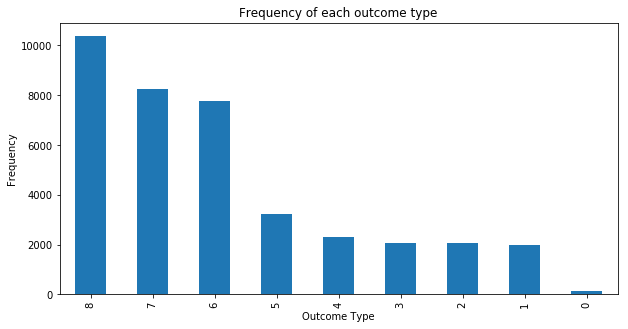

In [108]:
#Drawing a count plot of dependent variable to check the biasness of prediction in data present
bx = pd.DataFrame(y_train_check)['outcome_type'].value_counts().plot(kind='bar',figsize=(10,5),title="Frequency of each outcome type")
bx.set_xlabel("Outcome Type")
bx.set_ylabel("Frequency")

In [109]:
print("Class distribution count")
print(pd.DataFrame(y_train_check)['outcome_type'].value_counts())
print("Class distribution percent(%)")
print(pd.DataFrame(y_val_check)['outcome_type'].value_counts(normalize = True)*100)

Class distribution count
8    10392
7     8261
6     7785
5     3247
4     2305
3     2058
2     2055
1     1991
0      148
Name: outcome_type, dtype: int64
Class distribution percent(%)
8    26.932329
7    21.796883
6    20.217550
5     9.381864
3     5.658404
4     5.480598
2     5.417843
1     4.800753
0     0.313775
Name: outcome_type, dtype: float64


This implies we are good to go with this training data set as it is showing same stats as that of combined dataset.

In [110]:
y_train_check.unique()

array([6, 8, 3, 7, 4, 2, 5, 1, 0])

# Modelling(Initial iterations)

** Starting with lightgbm test**

** Test 1**

In [61]:
import lightgbm as lgb

In [62]:
check_train_data=lgb.Dataset(X_train_check,label=y_train_check)

In [63]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':9,
    'metric': 'multi_logloss',
    'learning_rate': 0.0023,
    'max_depth': 7,
    'num_leaves': 16,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17 }

In [64]:
lgb_cv = lgb.cv(params, check_train_data, num_boost_round=10000, nfold=3, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))
print(nround)

model = lgb.train(params, check_train_data, num_boost_round=nround)

[20]	cv_agg's multi_logloss: 2.14542 + 0.000106581
[40]	cv_agg's multi_logloss: 2.09946 + 0.000298733
[60]	cv_agg's multi_logloss: 2.05783 + 0.000378882
[80]	cv_agg's multi_logloss: 2.01738 + 0.00046883
[100]	cv_agg's multi_logloss: 1.98084 + 0.000670789
[120]	cv_agg's multi_logloss: 1.94608 + 0.000781544
[140]	cv_agg's multi_logloss: 1.91242 + 0.000966586
[160]	cv_agg's multi_logloss: 1.884 + 0.00101874
[180]	cv_agg's multi_logloss: 1.85675 + 0.00102658
[200]	cv_agg's multi_logloss: 1.83109 + 0.0010926
[220]	cv_agg's multi_logloss: 1.80755 + 0.00115705
[240]	cv_agg's multi_logloss: 1.78416 + 0.0012629
[260]	cv_agg's multi_logloss: 1.76139 + 0.00136344
[280]	cv_agg's multi_logloss: 1.74086 + 0.00139577
[300]	cv_agg's multi_logloss: 1.72099 + 0.00140415
[320]	cv_agg's multi_logloss: 1.70242 + 0.00145862
[340]	cv_agg's multi_logloss: 1.68434 + 0.00151531
[360]	cv_agg's multi_logloss: 1.66758 + 0.00156229
[380]	cv_agg's multi_logloss: 1.65126 + 0.00158288
[400]	cv_agg's multi_logloss: 1.6

[3200]	cv_agg's multi_logloss: 1.21374 + 0.00459621
[3220]	cv_agg's multi_logloss: 1.21329 + 0.00458747
[3240]	cv_agg's multi_logloss: 1.21286 + 0.00457631
[3260]	cv_agg's multi_logloss: 1.21244 + 0.00456999
[3280]	cv_agg's multi_logloss: 1.21203 + 0.00457611
[3300]	cv_agg's multi_logloss: 1.21162 + 0.00456112
[3320]	cv_agg's multi_logloss: 1.21117 + 0.00456434
[3340]	cv_agg's multi_logloss: 1.21079 + 0.00459178
[3360]	cv_agg's multi_logloss: 1.21044 + 0.00458697
[3380]	cv_agg's multi_logloss: 1.21008 + 0.00457505
[3400]	cv_agg's multi_logloss: 1.20969 + 0.00460282
[3420]	cv_agg's multi_logloss: 1.20925 + 0.0045909
[3440]	cv_agg's multi_logloss: 1.20888 + 0.00457783
[3460]	cv_agg's multi_logloss: 1.20852 + 0.00457667
[3480]	cv_agg's multi_logloss: 1.20816 + 0.00456585
[3500]	cv_agg's multi_logloss: 1.20784 + 0.00455796
[3520]	cv_agg's multi_logloss: 1.20756 + 0.00455938
[3540]	cv_agg's multi_logloss: 1.2072 + 0.00454093
[3560]	cv_agg's multi_logloss: 1.20684 + 0.00453796
[3580]	cv_agg'

[6380]	cv_agg's multi_logloss: 1.18539 + 0.00454587
[6400]	cv_agg's multi_logloss: 1.18534 + 0.00454641
[6420]	cv_agg's multi_logloss: 1.18529 + 0.00455454
[6440]	cv_agg's multi_logloss: 1.18523 + 0.00454722
[6460]	cv_agg's multi_logloss: 1.18517 + 0.00455204
[6480]	cv_agg's multi_logloss: 1.18513 + 0.00455588
[6500]	cv_agg's multi_logloss: 1.18509 + 0.00455491
[6520]	cv_agg's multi_logloss: 1.18503 + 0.00456239
[6540]	cv_agg's multi_logloss: 1.18497 + 0.00457332
[6560]	cv_agg's multi_logloss: 1.18492 + 0.00459427
[6580]	cv_agg's multi_logloss: 1.18487 + 0.00458459
[6600]	cv_agg's multi_logloss: 1.18484 + 0.00460223
[6620]	cv_agg's multi_logloss: 1.18479 + 0.00459772
[6640]	cv_agg's multi_logloss: 1.18474 + 0.00460085
[6660]	cv_agg's multi_logloss: 1.18469 + 0.00461061
[6680]	cv_agg's multi_logloss: 1.18464 + 0.00461173
[6700]	cv_agg's multi_logloss: 1.1846 + 0.00462647
[6720]	cv_agg's multi_logloss: 1.18455 + 0.00462972
[6740]	cv_agg's multi_logloss: 1.18451 + 0.00461719
[6760]	cv_agg

In [65]:
check_y_pred = model.predict(X_val_check)

In [70]:
best_preds_check = np.asarray([np.argmax(line) for line in check_y_pred])


In [72]:
from sklearn.metrics import f1_score
f1_score(best_preds_check, y_val_check , average = 'micro')

0.6429243802949483

** Test 2**

In [80]:
params2 = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':9,
    'metric': 'multi_logloss',
    'learning_rate': 0.0023,
    'max_depth': 7,
    'num_leaves': 34,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17 }

In [81]:
lgb_cv = lgb.cv(params2, check_train_data, num_boost_round=10000, nfold=3, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=200)

nround2 = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))
print(nround)

model2 = lgb.train(params, check_train_data, num_boost_round=nround2)

[20]	cv_agg's multi_logloss: 2.14368 + 8.23993e-05
[40]	cv_agg's multi_logloss: 2.09622 + 0.000283427
[60]	cv_agg's multi_logloss: 2.05328 + 0.000361305
[80]	cv_agg's multi_logloss: 2.01165 + 0.000460178
[100]	cv_agg's multi_logloss: 1.97416 + 0.000602464
[120]	cv_agg's multi_logloss: 1.93857 + 0.000671158
[140]	cv_agg's multi_logloss: 1.90409 + 0.000840588
[160]	cv_agg's multi_logloss: 1.87508 + 0.000900231
[180]	cv_agg's multi_logloss: 1.84731 + 0.000938249
[200]	cv_agg's multi_logloss: 1.82112 + 0.000990124
[220]	cv_agg's multi_logloss: 1.79716 + 0.00104711
[240]	cv_agg's multi_logloss: 1.77333 + 0.00111044
[260]	cv_agg's multi_logloss: 1.75009 + 0.00121626
[280]	cv_agg's multi_logloss: 1.72922 + 0.0012154
[300]	cv_agg's multi_logloss: 1.70902 + 0.00121759
[320]	cv_agg's multi_logloss: 1.69008 + 0.00128727
[340]	cv_agg's multi_logloss: 1.67174 + 0.00133445
[360]	cv_agg's multi_logloss: 1.65466 + 0.00135764
[380]	cv_agg's multi_logloss: 1.63813 + 0.00136543
[400]	cv_agg's multi_loglo

[3220]	cv_agg's multi_logloss: 1.20149 + 0.00440588
[3240]	cv_agg's multi_logloss: 1.20111 + 0.00440666
[3260]	cv_agg's multi_logloss: 1.20073 + 0.00439872
[3280]	cv_agg's multi_logloss: 1.20037 + 0.00440027
[3300]	cv_agg's multi_logloss: 1.20001 + 0.00438168
[3320]	cv_agg's multi_logloss: 1.19961 + 0.0043858
[3340]	cv_agg's multi_logloss: 1.19927 + 0.00442111
[3360]	cv_agg's multi_logloss: 1.19897 + 0.00441498
[3380]	cv_agg's multi_logloss: 1.19865 + 0.00441558
[3400]	cv_agg's multi_logloss: 1.19831 + 0.00445135
[3420]	cv_agg's multi_logloss: 1.19791 + 0.00444322
[3440]	cv_agg's multi_logloss: 1.19758 + 0.00443687
[3460]	cv_agg's multi_logloss: 1.19727 + 0.00442804
[3480]	cv_agg's multi_logloss: 1.19696 + 0.00441896
[3500]	cv_agg's multi_logloss: 1.19668 + 0.00441451
[3520]	cv_agg's multi_logloss: 1.19644 + 0.00442554
[3540]	cv_agg's multi_logloss: 1.19612 + 0.00441128
[3560]	cv_agg's multi_logloss: 1.19581 + 0.0044118
[3580]	cv_agg's multi_logloss: 1.19551 + 0.00442822
[3600]	cv_agg'

[6400]	cv_agg's multi_logloss: 1.18029 + 0.00452273
[6420]	cv_agg's multi_logloss: 1.18028 + 0.00452967
[6440]	cv_agg's multi_logloss: 1.18027 + 0.00451914
[6460]	cv_agg's multi_logloss: 1.18024 + 0.00452898
[6480]	cv_agg's multi_logloss: 1.18024 + 0.00453243
[6500]	cv_agg's multi_logloss: 1.18024 + 0.00454639
[6520]	cv_agg's multi_logloss: 1.18024 + 0.0045608
[6540]	cv_agg's multi_logloss: 1.18023 + 0.00457526
[6560]	cv_agg's multi_logloss: 1.18022 + 0.00458599
[6580]	cv_agg's multi_logloss: 1.1802 + 0.0045668
[6600]	cv_agg's multi_logloss: 1.18021 + 0.00457481
[6620]	cv_agg's multi_logloss: 1.18019 + 0.00458047
[6640]	cv_agg's multi_logloss: 1.18019 + 0.00458358
[6660]	cv_agg's multi_logloss: 1.18019 + 0.00459461
[6680]	cv_agg's multi_logloss: 1.18019 + 0.00460403
[6700]	cv_agg's multi_logloss: 1.18019 + 0.00460704
[6720]	cv_agg's multi_logloss: 1.18019 + 0.00460461
[6740]	cv_agg's multi_logloss: 1.18019 + 0.00458339
[6760]	cv_agg's multi_logloss: 1.18018 + 0.00461057
[6780]	cv_agg's

In [82]:
check_y_pred2 = model2.predict(X_val_check)

In [83]:
check_best_pred2 = np.asarray([np.argmax(line) for line in check_y_pred2])

In [84]:
from sklearn.metrics import f1_score
f1_score(check_best_pred2, y_val_check , average = 'micro')

0.6414600983160758

**Test 3**

In [1]:
model3 = XGBClassifier(learning_rate =0.1,n_estimators=250,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)


NameError: name 'XGBClassifier' is not defined

In [97]:
model3.fit(X_train_check, y_train_check, eval_metric = 'mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=True, subsample=0.8)

In [75]:
check_y_pred3 = model3.predict(X_val_check)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [78]:
from sklearn.metrics import f1_score
f1_score(check_y_pred3, y_val_check , average = 'micro')

0.6444932538437402

**Test 4**

In [91]:
model4 = XGBClassifier(learning_rate =0.05,n_estimators=1000,max_depth=5 ,min_child_weight=1, gamma=5, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)

In [92]:
model4.fit(X_train_check, y_train_check, eval_metric = 'mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=True, subsample=0.8)

In [93]:
check_y_pred4 = model4.predict(X_val_check)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [130]:
from sklearn.metrics import f1_score
f1_score(check_y_pred4, y_val_check.iloc[:] , average = 'micro')

0.6402049994770421

Model3 has max f1 score , now lets plot the feature importance curve

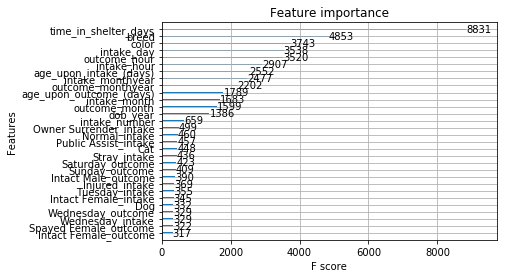

In [104]:
# plot feature importance
from xgboost import plot_importance
plot_importance(model3, max_num_features= 30)
pyplot.figure(figsize=(20,10))
pyplot.show()

In [113]:
modelcheck(model=model3, X_train_encoded=X_train_check,X_test_encoded = X_val_check,y_train = y_train_check, y_test = y_val_check, model_with_param = XGBClassifier(learning_rate =0.1,n_estimators=250,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234))

Thresh=0.000, n=57, Accuracy: 64.45%
Thresh=0.001, n=56, Accuracy: 64.43%
Thresh=0.001, n=55, Accuracy: 64.34%
Thresh=0.001, n=54, Accuracy: 64.49%
Thresh=0.001, n=54, Accuracy: 64.49%
Thresh=0.002, n=52, Accuracy: 64.34%
Thresh=0.002, n=51, Accuracy: 64.22%
Thresh=0.004, n=50, Accuracy: 64.26%
Thresh=0.004, n=49, Accuracy: 64.41%
Thresh=0.004, n=48, Accuracy: 64.23%
Thresh=0.004, n=47, Accuracy: 64.53%
Thresh=0.005, n=46, Accuracy: 64.31%
Thresh=0.005, n=45, Accuracy: 64.39%
Thresh=0.005, n=44, Accuracy: 64.30%
Thresh=0.005, n=43, Accuracy: 63.98%
Thresh=0.005, n=42, Accuracy: 64.54%
Thresh=0.005, n=41, Accuracy: 64.29%
Thresh=0.005, n=40, Accuracy: 64.38%
Thresh=0.005, n=39, Accuracy: 64.31%
Thresh=0.005, n=38, Accuracy: 64.26%
Thresh=0.005, n=37, Accuracy: 64.37%
Thresh=0.006, n=36, Accuracy: 64.32%
Thresh=0.006, n=35, Accuracy: 64.33%
Thresh=0.006, n=35, Accuracy: 64.33%
Thresh=0.006, n=33, Accuracy: 64.20%
Thresh=0.006, n=32, Accuracy: 64.31%
Thresh=0.006, n=31, Accuracy: 64.31%
T

This clearly gives an idea that at n=42 we achieve maximun accuracy. Hence we need to discard more variables for better prediction in the future.

But we need to be very careful as some of the less important feature can contribute in prediction of minority class.

In [122]:
sorted_idx = np.argsort(model3.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train_check.columns[index], model3.feature_importances_[index]]) 

['time_in_shelter_days', 0.16447821]
['breed', 0.09038759]
['color', 0.069713734]
['intake_day', 0.06589559]
['outcome_hour', 0.06556033]
['intake_hour', 0.054143153]
['age_upon_intake_(days)', 0.047531243]
['intake_monthyear', 0.04613436]
['outcome_monthyear', 0.04101246]
['age_upon_outcome_(days)', 0.033320297]
['intake_month', 0.031346034]
['outcome_month', 0.029781528]
['dob_year', 0.025814382]
['intake_number', 0.012273937]
['Owner Surrender_intake', 0.009293922]
['Normal_intake', 0.008567544]
['Public Assist_intake', 0.008511669]
['Cat', 0.008344043]
['Stray_intake', 0.008120541]
['Saturday_outcome', 0.007878415]
['Sunday_outcome', 0.007617664]
['Intact Male_outcome', 0.007263787]
['Injured_intake', 0.00687266]
['Tuesday_intake', 0.006611909]
['Intact Female_intake', 0.006425658]
['Dog', 0.0061835316]
['Wednesday_outcome', 0.0061276564]
['Wednesday_intake', 0.0061276564]
['Spayed Female_outcome', 0.0059972806]
['Intact Female_outcome', 0.0059041553]
['Neutered Male_outcome', 0.00

We need to drop some of the weak predictor variable to tweak our model performance also we need to create some more variables for better performance of model. As per our hypothesis we will be eliminating outcome_year as it is a weak predictor.

Note i performed the above check to quickly drop some useless predefined variables. I will be dropping the lower predicting dummy variables later. Hence dropping **outcome_year**

In [267]:
X = X.drop(['outcome_year'], axis  = 1)

ValueError: labels ['outcome_year'] not contained in axis

# 6. Feature Engineering:

Lets try to create some more informative features


In [268]:
import re
def breed_check(breed):
    r1 = re.search(r'\/', breed)
    if r1:
        check = str(r1.group())
    else:
        check = 'not_found'
    r2 = re.search(r'Mix', breed)
    if r2:
        check2 = str(r2.group())
    else:
        check2 = 'not_found'
    if check=='/':
        breed_type = 'specific_mix' # AS NOT MENTIONED IN PROBLEM STATEMENT THIS IS WHAT MY ASSUMPTION IS.
    elif check2 == 'Mix':
        breed_type = 'unknown_mix'
    else:
        breed_type = 'pure'
    return breed_type   

In [269]:
X['breed_bucket'] = X.breed.apply(breed_check)

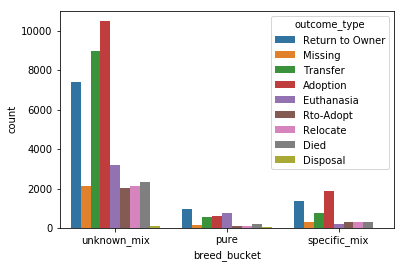

In [270]:
sns.countplot(x= 'breed_bucket', hue="outcome_type", data= X)

This gives us an idea that that unknown mix bread type are either more adopted or transfered, pure bread type animal is either 

In [271]:
#Trying to create some strengthing variable for the minority class
def adopt_conditions(df):
    if (df['outcome_type']=='Adoption'):      #made changes here removed !=Others
        return df['breed']
    
adoptable_dict = pd.DataFrame(X.apply(adopt_conditions, axis = 1), columns = ['adoptable_breeds'])
cleaned_adoptable_dict = adoptable_dict[adoptable_dict['adoptable_breeds'].notnull()]
cleaned_adoptable_dict = pd.DataFrame(cleaned_adoptable_dict['adoptable_breeds'].unique(), columns = ['unique_adoptable_breeds'])
adoptable_list = cleaned_adoptable_dict['unique_adoptable_breeds'].tolist()

In [272]:
X[X['outcome_type']=='Rto-Adopt']

,dob_year,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(days),outcome_month,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type,intake_day,breed_bucket
41,2000,Cat,Domestic Longhair Mix,Black/White,Normal,Stray,Neutered Male,5110,10,2014,201410,Thursday,18,1.0,3.814583,Neutered Male,5110,10,201410,Monday,13,Rto-Adopt,16,unknown_mix
65,2002,Cat,Domestic Shorthair,Blue Cream/Tortie,Injured,Stray,Spayed Female,5475,4,2017,201704,Thursday,17,1.0,5.815278,Spayed Female,5475,4,201704,Wednesday,12,Rto-Adopt,20,pure
159,2004,Cat,Domestic Shorthair Mix,Silver Tabby,Normal,Stray,Spayed Female,4745,4,2017,201704,Thursday,16,1.0,11.830556,Spayed Female,4745,4,201704,Tuesday,12,Rto-Adopt,13,unknown_mix
216,2004,Dog,Miniature Poodle/Cairn Terrier,White/Cream,Normal,Stray,Neutered Male,4745,6,2017,201706,Sunday,17,2.0,5.062500,Neutered Male,4745,6,201706,Friday,18,Rto-Adopt,4,specific_mix
253,2003,Cat,Domestic Shorthair Mix,Black,Normal,Owner Surrender,Spayed Female,4380,11,2015,201511,Thursday,13,1.0,205.920139,Spayed Female,4380,6,201606,Sunday,11,Rto-Adopt,19,unknown_mix
350,2005,Cat,Siamese Mix,Chocolate Point,Normal,Owner Surrender,Neutered Male,2920,1,2014,201401,Saturday,14,1.0,5.105556,Neutered Male,2920,1,201401,Thursday,17,Rto-Adopt,4,unknown_mix
414,2006,Dog,Chihuahua Longhair/Pekingese,White/Red,Sick,Owner Surrender,Spayed Female,3285,9,2015,201509,Saturday,15,1.0,9.031944,Spayed Female,3285,10,201510,Monday,16,Rto-Adopt,26,specific_mix
448,2006,Cat,Domestic Shorthair Mix,Blue,Normal,Stray,Spayed Female,3650,7,2017,201707,Friday,13,1.0,7.989583,Spayed Female,3650,7,201707,Saturday,13,Rto-Adopt,21,unknown_mix
538,2005,Dog,Chow Chow/Pekingese,Black,Normal,Owner Surrender,Spayed Female,4380,4,2017,201704,Friday,14,1.0,142.061806,Spayed Female,4380,9,201709,Sunday,16,Rto-Adopt,21,specific_mix
545,2007,Dog,West Highland/Toy Fox Terrier,White,Normal,Stray,Intact Male,2920,4,2016,201604,Saturday,15,2.0,5.153472,Neutered Male,2920,4,201604,Thursday,19,Rto-Adopt,2,specific_mix


In [273]:
#Trying to create some strengthing variable for the minority class
def rto_adopt_conditions(df):
    if (df['outcome_type']== 'Rto-Adopt'):      #made changes here removed !=Others
        return df['breed']
    
rto_adoptable_dict = pd.DataFrame(X.apply(rto_adopt_conditions, axis = 1), columns = ['rto_adoptable_breeds'])
rto_cleaned_adoptable_dict = rto_adoptable_dict[rto_adoptable_dict['rto_adoptable_breeds'].notnull()]
rto_cleaned_adoptable_dict = pd.DataFrame(rto_cleaned_adoptable_dict['rto_adoptable_breeds'].unique(), columns = ['unique_rto_adoptable_breeds'])
rto_adoptable_list = rto_cleaned_adoptable_dict['unique_rto_adoptable_breeds'].tolist()

In [274]:
def disposal_conditions(df):
    if (df['outcome_type']=='Disposal'):
        return df['breed']
    
disposal_dict = pd.DataFrame(X.apply(disposal_conditions, axis = 1), columns = ['disposal_breeds'])
cleaned_disposal_dict = disposal_dict[disposal_dict['disposal_breeds'].notnull()]
cleaned_disposal_dict = pd.DataFrame(cleaned_disposal_dict['disposal_breeds'].unique(), columns = ['unique_disposal_breeds'])
disposal_list = cleaned_disposal_dict['unique_disposal_breeds'].tolist()

In [275]:
disposal_list

['Bat Mix',
 'Raccoon',
 'Bat',
 'Raccoon Mix',
 'Fox',
 'Skunk Mix',
 'Squirrel',
 'Opossum Mix',
 'Domestic Shorthair Mix',
 'Skunk',
 'Snake/Snake',
 'American Bulldog Mix',
 'Chihuahua Shorthair/Dachshund',
 'Siamese Mix',
 'Opossum',
 'Pigeon Mix',
 'Squirrel Mix',
 'Coyote Mix',
 'Chicken Mix',
 'Fox Mix',
 'German Shepherd Mix']

In [276]:
def lookup_adotable_breeds(breed):
    if breed in adoptable_list:
        return 'adoptible_likely'          #made changes returns here
    else:
        return 'adoptible_unlikely'        #made changes returns here
    
def lookup_rto_adoptabale_breeds(breed):
    if breed in rto_adoptable_list:
        return 'rto_adoptible_likely'          #made changes returns here
    else:
        return 'rto_adoptible_unlikely'        #made changes returns here
        
def lookup_disposable_breeds(breed):
    if breed in disposal_list:
        return 'high_disposability'
    else:
        return 'low_disposability'

In [277]:
X['adoptability'] = X.breed.apply(lookup_adotable_breeds)
X['disposability'] = X.breed.apply(lookup_disposable_breeds)
X['rto_adoptability']= X.breed.apply(lookup_rto_adoptabale_breeds)

In [278]:
#We are excluding dogs because only 2 dogs are disposed.
X.loc[X['animal_type']=='Dog', 'disposability'] = 'low_disposability'

# Feature encoding(final iteration)

In [293]:
X_final = X.copy()

In [294]:
#FINAL ONE HOT ENCODING
def onehotdataframe_final(dfs):  
    one_hot_animal_type= pd.get_dummies(dfs.animal_type)

    one_hot_intake_condition = pd.get_dummies(dfs.intake_condition)
    one_hot_intake_condition.columns = [str(col) + '_intake' for col in one_hot_intake_condition.columns]

    one_hot_intake_type = pd.get_dummies(dfs.intake_type)
    one_hot_intake_type.columns = [str(col) + '_intake' for col in one_hot_intake_type.columns]

    one_hot_sex_upon_intake = pd.get_dummies(dfs.sex_upon_intake)
    one_hot_sex_upon_intake.columns = [str(col) + '_intake' for col in one_hot_sex_upon_intake.columns]

    one_hot_intake_weekday = pd.get_dummies(dfs.intake_weekday)
    one_hot_intake_weekday.columns = [str(col) + '_intake' for col in one_hot_intake_weekday.columns]

    one_hot_sex_upon_outcome = pd.get_dummies(dfs.sex_upon_outcome)
    one_hot_sex_upon_outcome.columns = [str(col) + '_outcome' for col in one_hot_sex_upon_outcome.columns]

    one_hot_outcome_weekday = pd.get_dummies(dfs.outcome_weekday)
    one_hot_outcome_weekday.columns = [str(col) + '_outcome' for col in one_hot_outcome_weekday.columns]     
    
    one_hot_breed_bucket = pd.get_dummies(dfs.breed_bucket)
    one_hot_breed_bucket.columns = [str(col) + '_breed_category' for col in one_hot_breed_bucket.columns]  
    
    dfs = dfs.drop(['animal_type','intake_type', 'intake_condition', 'sex_upon_intake', 'intake_weekday', 'sex_upon_outcome', 'outcome_weekday', 'breed_bucket'], axis = 1) 

    #Merging one hot encoded features with our dataset 'data' 
    df_encoded=pd.concat([dfs, one_hot_animal_type,one_hot_intake_condition,one_hot_intake_type,one_hot_sex_upon_intake,one_hot_intake_weekday,one_hot_sex_upon_outcome,one_hot_outcome_weekday, one_hot_breed_bucket],axis=1)  
    
    return(df_encoded)

In [295]:
X_final = onehotdataframe_final(dfs = X_final)

In [296]:
X_final

,dob_year,breed,color,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_hour,intake_number,time_in_shelter_days,age_upon_outcome_(days),outcome_month,outcome_monthyear,outcome_hour,outcome_type,intake_day,adoptability,disposability,rto_adoptability,Bird,Cat,Dog,Other,Aged_intake,Feral_intake,Injured_intake,Normal_intake,Nursing_intake,Other_intake,Pregnant_intake,Sick_intake,Euthanasia Request_intake,Owner Surrender_intake,Public Assist_intake,Stray_intake,Wildlife_intake,Intact Female_intake,Intact Male_intake,Neutered Male_intake,Spayed Female_intake,Unknown_intake,Friday_intake,Monday_intake,Saturday_intake,Sunday_intake,Thursday_intake,Tuesday_intake,Wednesday_intake,Intact Female_outcome,Intact Male_outcome,Neutered Male_outcome,Spayed Female_outcome,Unknown_outcome,Friday_outcome,Monday_outcome,Saturday_outcome,Sunday_outcome,Thursday_outcome,Tuesday_outcome,Wednesday_outcome,pure_breed_category,specific_mix_breed_category,unknown_mix_breed_category
0,2007,Spinone Italiano Mix,Yellow/White,3650,12,2017,201712,14,1.0,0.588194,3650,12,201712,0,Return to Owner,7,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,2007,Spinone Italiano Mix,Yellow/White,2555,12,2014,201412,10,2.0,1.259722,2555,12,201412,16,Return to Owner,19,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,2007,Spinone Italiano Mix,Yellow/White,2190,3,2014,201403,14,3.0,1.113889,2190,3,201403,17,Return to Owner,7,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,2004,Dachshund,Tricolor,3650,4,2014,201404,15,1.0,4.970139,3650,4,201404,15,Missing,2,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
4,1997,Shetland Sheepdog,Brown/White,5840,11,2013,201311,9,1.0,0.119444,5840,11,201311,11,Return to Owner,16,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5,1998,Labrador Retriever/Pit Bull,Black/White,5475,11,2013,201311,14,1.0,0.870833,5475,11,201311,11,Return to Owner,16,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
6,1999,Miniature Schnauzer Mix,Black/Gray,5475,11,2014,201411,15,1.0,0.178472,5475,11,201411,19,Return to Owner,14,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
7,1999,Lhasa Apso Mix,Brown/White,5475,9,2014,201409,11,1.0,0.213194,5475,9,201409,16,Return to Owner,15,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
8,1999,Shetland Sheepdog Mix,White/Black,5475,3,2014,201403,9,1.0,6.258333,5475,3,201403,15,Return to Owner,17,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
9,1997,Shetland Sheepdog Mix,Brown/White,6570,9,2015,201509,17,1.0,0.054167,6570,9,201509,19,Return to Owner,18,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [297]:
X_final['adoptability'] = X_final['adoptability'].map({'adoptible_unlikely' : 0, 'adoptible_likely' : 1 })
X_final['disposability'] = X_final['disposability'].map({'low_disposability' : 0, 'high_disposability' : 1 })
X_final['rto_adoptability'] = X_final['rto_adoptability'].map({'rto_adoptible_unlikely' : 0, 'rto_adoptible_likely' : 1 })

In [298]:
X_final['outcome_type'] = X_final['outcome_type'].map({'Adoption' : 8, 'Transfer': 7, 'Return to Owner' : 6, 'Euthanasia' : 5, 'Died' : 4, 'Missing' : 3, 'Relocate' : 2, 'Rto-Adopt' : 1, 'Disposal' : 0})

In [299]:
y_final = X_final['outcome_type']
X_final= X_final.drop(['outcome_type'], axis = 1)

In [300]:
X_final_copy = X_final.copy()

In [301]:
X_final_copy = X_final_copy.drop(['breed', 'color'], axis = 1)
X_final_copy['intake_monthyear'] = X_final_copy.intake_monthyear.astype(int)
X_final_copy['outcome_monthyear'] = X_final_copy.outcome_monthyear.astype(int)

** Dropping breed and color because i already tried to bucket these categorical features with "adoptablity","disposability" , "breed_bucket"**

In [302]:
print(X_final_copy.shape, y_final.shape)

(47803, 60) (47803,)


In [303]:
print('Missing value in training set:', X_final_copy.isnull().sum().max())

Missing value in training set: 0


** Converting into train and validation set **

In [304]:
# Splitting the dataset into the Training set and Test set.
X_train, X_val, y_train, y_val = train_test_split(X_final_copy, y_final, test_size = 0.2, random_state = 20)
#Split is 80%-20% for testing. Here X_test~Validation set.


print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(38242, 60) (9561, 60) (38242,) (9561,)


In [305]:
X_train['intake_monthyear'] = X_train.intake_monthyear.astype(int)
X_val['intake_monthyear'] = X_val.intake_monthyear.astype(int)
X_train['outcome_monthyear'] = X_train.outcome_monthyear.astype(int)
X_val['outcome_monthyear'] = X_val.outcome_monthyear.astype(int)

# TEST 5 64 leaves LIGHTGBM

In [306]:
import lightgbm as lightgbmmodel
from lightgbm import LGBMClassifier as lgb

In [307]:
model5 = lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  20, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2500, random_state =1234) 

In [212]:
model5.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=17, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
        importance_type='split', learning_rate=0.0026, max_depth=20,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=2500,
        n_jobs=-1, num_class=9, num_leaves=64, objective='multiclass',
        random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        task='train')

In [213]:
y_pred1 = model5.predict(X_val)

In [214]:
y_pred1

array([8, 8, 8, ..., 7, 7, 7])

In [215]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6410417320363979

In [126]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6283861520761427

In [135]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6237841229996862

In [139]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6249346302688004

In [144]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6375902102290555

In [153]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

#After dropping color

0.6373810270892166

In [157]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#max bin added with value 255

0.6369626608095388

In [162]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6374856186591361

In [167]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#increasing learning rate to 0.05

0.6240978977094446

In [172]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#increasing learning rate to 0.05

0.630268800334693

In [177]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#increasing learning rate to 0.05

0.6373810270892166

In [178]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6373810270892166

In [187]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')

0.6375902102290555

In [193]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  10, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2000, random_state =1234) 

0.6397866331973643

In [198]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
max_depth =15

0.64062336575672

In [202]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
max_depth  = 20

0.6408325488965589

In [208]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  20, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2000, random_state =1234) 

0.6408325488965589

In [212]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  20, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2500, random_state =1234) 

0.6422968308754314

In [216]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  20, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 3000, random_state =1234) 

0.6436565212843844

In [224]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  20, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 3000, random_state =1234)
#dropping color

0.6437611128543039

In [232]:
from sklearn.metrics import f1_score
f1_score(y_pred1, y_val.iloc[:] , average = 'micro')
#lgb(task =  'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  20, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 10000, random_state =1234)
#dropping color

0.6441794791339818

# TEST 6 Xgboost

In [305]:
model6 = XGBClassifier(learning_rate =0.1, n_estimators= 500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
model6.fit(X_train, y_train, eval_metric = 'mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=True, subsample=0.8)

In [306]:
y_pred2 = model6.predict(X_val)

In [253]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators= 1000,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#dropping color

0.6434473381445456

In [242]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.05,n_estimators=250,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#eta dropped to 0.05

0.639263675347767

In [245]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.05,n_estimators=250,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#eta back to 0.1
#n_estimators reduced to 100

0.6390544922079281

In [248]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.05,n_estimators=500,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#eta back to 0.1
#n_estimators increased to 500

0.6438657044242234

In [258]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=1000,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#eta back to 0.1
#n_estimators increased to 1000

0.6383223512184918

In [261]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.2,n_estimators=500,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#n_estimators rolled back to 500
#eta pushed to 0.2

0.6333019558623575

In [264]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=500,max_depth=5 ,min_child_weight=1, gamma=2, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#eta rolled back to 0.1
#gamma increased to 2

0.6443886622738207

In [267]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=500,max_depth=5 ,min_child_weight=1, gamma=4, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#gamma increased to 4

0.6430289718648677

In [270]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=500,max_depth=5 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#gamma reduced to 3

0.6444932538437402

In [292]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=500,max_depth=3 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#gamma reduced to 3
#keeping breed and removing color
#reducing max_depth to 3

0.6429243802949483

In [295]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#gamma reduced to 3
#keeping breed and removing color
#increasing max_depth to 3

0.6513962974584249

In [304]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators=500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.6,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#gamma reduced to 3
#keeping breed and removing color
#rolling subsample back to 0.8
#reducing colsample_bytree to 0.6


0.6510825227486664

In [ ]:
xgbcheck = XGBClassifier(learning_rate =0.1,n_estimators=500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
xgbcheck.fit(X_train, y_train)
sorted_idx = np.argsort(model3.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train_check.columns[index], model8.feature_importances_[index]])

Observations:

1. Unknown_intake and unknown_outcome are same column hence dropping one, lets drop unknown_intake
2. Also dropping intake_year and Thursday_intake as they are poor predictors as expected. 

In [308]:
X_train_final = X_train.drop(['Unknown_intake', 'intake_year', 'Thursday_intake'], axis = 1)
X_val_final = X_val.drop(['Unknown_intake' , 'intake_year', 'Thursday_intake'], axis = 1)

In [311]:
model8 = XGBClassifier(learning_rate =0.1,n_estimators=500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
model8.fit(X_train_final, y_train)
y_pred4 = model8.predict(X_val_final)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))

Thresh=0.005, n=57, Accuracy: 64.50%


**Best xgboost model = model8**

**Best lightgbm model = model5**

**Comparison with other models:**

MODEL3 - LOGISTIC REGRESSION:

In [316]:
#For other models feature scaling is necessary
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_trainf = sc_X.fit_transform(X_train_final)
X_testf= sc_X.transform(X_val_final)
y_trainf= y_train

lr= LogisticRegression(penalty = 'l2', random_state =1234, solver ='newton-cg', multi_class= 'multinomial' )
lr.fit(X_trainf, y_trainf)
y_predlr= lr.predict(X_testf)

In [317]:
predictions = [round(value) for value in y_predlr]
accuracy = accuracy_score(y_val, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))

Thresh=0.005, n=57, Accuracy: 58.30%


MODEL4- RANDOM FOREST

In [318]:
rf =  RandomForestClassifier(n_estimators= 1000 , criterion = 'entropy' , random_state = 0, bootstrap = True)
rf.fit(X_train_final, y_train)
y_predrf = rf.predict(X_val_final)
predictions = [round(value) for value in y_predrf]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_predrf, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 62.45%
f1 -score :  0.6245162639891225


# Predictions :

** Preparation of test set for predictions **

In [332]:
test = pd.read_csv('/Users/apple/Documents/Animal State Prediction - dataset/test.csv')

In [333]:
test.shape

(31869, 36)

In [334]:
test = test.drop(['outcome_datetime'], axis  = 1)
test = DataFrameImputer().fit_transform(pd.DataFrame(test))
test = test.drop(['count', 'outcome_number'], axis = 1)
test = test.drop(['animal_id_outcome'], axis = 1)
test = test.drop(['age_upon_intake', 'age_upon_intake_(years)', 'age_upon_intake_age_group', 'age_upon_outcome', 'age_upon_outcome_(years)', 'age_upon_outcome_age_group', 'date_of_birth','dob_month', 'time_in_shelter'], axis = 1)
test['intake_day'] = pd.DatetimeIndex(test['intake_datetime']).day
test = test.drop(['intake_datetime'], axis = 1)
test['intake_monthyear'] = test['intake_year'] * 100 + X['intake_month']
test['outcome_monthyear'] = test['outcome_year']* 100 + X['outcome_month']
test = test.drop(['outcome_year'], axis  = 1)
test['breed_bucket'] = test.breed.apply(breed_check)
test['adoptability'] = test.breed.apply(lookup_adotable_breeds)
test['disposability'] = test.breed.apply(lookup_disposable_breeds)
test['rto_adoptability'] = test.breed.apply(lookup_rto_adoptabale_breeds)
#We are excluding dogs because only 2 dogs are disposed.
test.loc[test['animal_type']=='Dog', 'disposability'] = 'low_disposability'
test['intake_monthyear'] = test.intake_monthyear.astype(int)
test['outcome_monthyear'] = test.outcome_monthyear.astype(int)

In [335]:
test_final = test.copy()
test_final.shape

(31869, 26)

In [336]:
test_final = onehotdataframe_final(dfs = test_final)

In [337]:
test_final.shape

(31869, 62)

In [338]:
test_final['adoptability'] = test_final['adoptability'].map({'adoptible_unlikely' : 0, 'adoptible_likely' : 1 })
test_final['disposability'] = test_final['disposability'].map({'low_disposability' : 0, 'high_disposability' : 1 })
test_final['rto_adoptability'] = test_final['rto_adoptability'].map({'rto_adoptible_unlikely' : 0, 'rto_adoptible_likely' : 1 })

In [339]:
test_final = test_final.drop(['breed'], axis = 1)

In [340]:
test_final = test_final.drop(['color'], axis = 1)

In [341]:
#testing
test_final = test_final.drop(['Unknown_intake', 'intake_year', 'Thursday_intake'], axis = 1)

In [342]:
#test_final = test_final.drop(['intake_monthyear'], axis = 1)

In [343]:
test_final.shape

(31869, 57)

** Below are iterative models that I used to check the performance of my different models on out of time validation set(i.e. test set) and select models accordingly **

In [313]:
#Testing subject to changes
X_train_final_check = X_train_final.drop(['intake_monthyear'], axis = 1)
X_val_final_check = X_val_final.drop(['intake_monthyear'], axis = 1)


In [320]:
#Including intake_monthyear
model5 = lgb(task = 'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  -1, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2500, random_state =1234,min_split_gain = 0, reg_alpha = 0, reg_lambda = 0 ) 
model5.fit(X_train_final, y_train)
y_pred4 = model5.predict(X_val_final)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 64.39%
f1 -score :  0.6438657044242234


In [401]:
model5 = lgb(task = 'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  -1, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2500, random_state =1234,min_split_gain = 0, reg_alpha = 0, reg_lambda = 0 ) 
model5.fit(X_train_final_check, y_train)
y_pred4 = model5.predict(X_val_final_check)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final_check.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 64.26%
f1 -score :  0.6426106055851898


In [428]:
print('Missing value in training set:', X_train_final_check.isnull().sum().max())

Missing value in training set: 0


In [429]:
#Excluding intake_monthyear
rf =  RandomForestClassifier(n_estimators= 1000 , criterion = 'entropy' , random_state = 0, bootstrap = True)
rf.fit(X_train_final_check, y_train)
y_pred4 = rf.predict(X_val_final_check)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 62.56%
f1 -score :  0.6255621796883172


In [319]:
#Including intake_monthyear
xgb = XGBClassifier(learning_rate =0.1, n_estimators= 500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=99, seed=1234)
xgb.fit(X_train_final, y_train, eval_metric = 'mlogloss')
y_pred4 = xgb.predict(X_val_final)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 64.50%
f1 -score :  0.6450162116933376


In [432]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators= 500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=99, seed=1234)
xgb.fit(X_train_final_check, y_train, eval_metric = 'mlogloss')
y_pred4 = xgb.predict(X_val_final_check)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 64.36%
f1 -score :  0.6435519297144651


Hence we will keep the intake_monthyear variable

In [322]:
estimators =[]
model1= model5
estimators.append(('lightgbm', model1))
model2=rf
estimators.append(('random_forest', model2))
model3=xgb
estimators.append(('xgboost', model3))
'''Ensembling now'''
ensemble = VotingClassifier(estimators, voting = 'soft', weights = [2,1,2])   #[2,1,2] best till now
ensemble.fit(X_train_final, y_train)

VotingClassifier(estimators=[('lightgbm', LGBMClassifier(bagging_fraction=0.6, bagging_freq=17, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
        importance_type='split', learning_rate=0.0026, max_depth=-1,
        metric='multi_logloss', min_child_samples=20,
     ...     reg_alpha=0, reg_lambda=1, scale_pos_weight=99, seed=1234,
       silent=True, subsample=0.8))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[2, 1, 2])

In [324]:
y_pred_ensemble = ensemble.predict(X_val_final)
predictions = [round(value) for value in y_pred_ensemble]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred_ensemble, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 64.88%
f1 -score :  0.6487815082104382


In [328]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_ensemble, y_val)

             precision    recall  f1-score   support

          0       0.40      0.92      0.56        13
          1       0.03      0.48      0.05        25
          2       0.00      0.09      0.00        11
          3       0.01      0.25      0.01        12
          4       0.03      0.50      0.05        30
          5       0.74      0.87      0.80       767
          6       0.84      0.85      0.85      1907
          7       0.72      0.58      0.64      2611
          8       0.92      0.56      0.70      4185

avg / total       0.83      0.65      0.72      9561



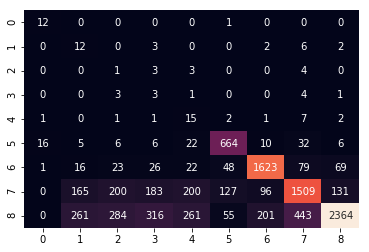

In [327]:
from sklearn.metrics import roc_auc_score
sns.heatmap(cm,annot=True,fmt="d", cbar = False)
print(classification_report(y_pred_ensemble, y_val))

In [406]:
final_predict1 = ensemble.predict(test_final)

In [407]:
predictions = pd.DataFrame(ml_dataset_test['animal_id_outcome'])
y_pred_df = pd.DataFrame(final_predict1, columns=['outcome_type'])
results = pd.concat([predictions, y_pred_df], axis=1)
results['outcome_type']= results['outcome_type'].map({ 8 :'Adoption', 7: 'Transfer', 6: 'Return to Owner', 5 : 'Euthanasia' , 4 : 'Died' , 3 : 'Missing' , 2 : 'Relocate' ,  1 : 'Rto-Adopt' , 0 : 'Disposal' }).astype(str)

In [408]:
results.to_csv('/Users/apple/Documents/Animal_State_Prediction_dataset/pred5_lgbm_64leavesestimator2_feb9_3.csv', index = False)

# Fitting entire dataset for best predictions for external test set

** Fitting on complete dataset i.e. X_final_copy**

In [329]:
X_final_copy = X_final_copy.drop(['Unknown_intake', 'intake_year', 'Thursday_intake'], axis = 1)
X_final_copy.shape

(47803, 57)

In [330]:
ensemble.fit(X_final_copy, y_final)

VotingClassifier(estimators=[('lightgbm', LGBMClassifier(bagging_fraction=0.6, bagging_freq=17, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
        importance_type='split', learning_rate=0.0026, max_depth=-1,
        metric='multi_logloss', min_child_samples=20,
     ...     reg_alpha=0, reg_lambda=1, scale_pos_weight=99, seed=1234,
       silent=True, subsample=0.8))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[2, 1, 2])

In [344]:
y_predfull = ensemble.predict(test_final)

In [345]:
predictions = pd.DataFrame(ml_dataset_test['animal_id_outcome'])
y_pred_df = pd.DataFrame(y_predfull, columns=['outcome_type'])
results = pd.concat([predictions, y_pred_df], axis=1)
results['outcome_type']= results['outcome_type'].map({ 8 :'Adoption', 7: 'Transfer', 6: 'Return to Owner', 5 : 'Euthanasia' , 4 : 'Died' , 3 : 'Missing' , 2 : 'Relocate' ,  1 : 'Rto-Adopt' , 0 : 'Disposal' }).astype(str)

In [346]:
results.to_csv('/Users/apple/Documents/Animal_State_Prediction_dataset/voting_feb9_full_withmnthyear.csv', index = False)


**Miscellaneous Models**

In [626]:
train_h2o = X_train_final.copy()
test_h2o = X_val_final.copy()
train_h2o_df = pd.concat([train_h2o, y_train], axis = 1)
test_h2o_df  = pd.concat([test_h2o, y_val], axis = 1)

In [630]:
#FITTING AUTO ML
#NOTE IT TAKES LOT OF TIME 
import h2o
from h2o.automl import H2OAutoML

h2o.init()

train_h2o_final = h2o.H2OFrame(train_h2o_df)
test_h2o_final = h2o.H2OFrame(test_h2o_df)

# Identify predictors and response
x = train_h2o_final.columns
y_h2o = "outcome_type"
x.remove(y_h2o)

# For binary classification, response should be a factor
train_h2o_final[y_h2o] = train_h2o_final[y_h2o].asfactor()
test_h2o_final[y_h2o] = test_h2o_final[y_h2o].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y_h2o, training_frame = train_h2o_final)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
aml.leader

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /anaconda3/h2o_jar/h2o.jar
  Ice root: /var/folders/ls/2kwg9_t972zcy47dxvc2m0rw0000gn/T/tmp6cwz7eou
  JVM stdout: /var/folders/ls/2kwg9_t972zcy47dxvc2m0rw0000gn/T/tmp6cwz7eou/h2o_apple_started_from_python.out
  JVM stderr: /var/folders/ls/2kwg9_t972zcy47dxvc2m0rw0000gn/T/tmp6cwz7eou/h2o_apple_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,07 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,10 months and 9 days !!!
H2O cluster name:,H2O_from_python_apple_o0g9ga
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_0_AutoML_20190114_202637_model_1


ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.3072121743529464
RMSE: 0.5542672409162808
LogLoss: 0.8912957910349716
Mean Per-Class Error: 0.48352281199020464
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,5,6,7,8,Error,Rate
97.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.1565217,18 / 115
0.0,140.0,7.0,1.0,2.0,7.0,44.0,542.0,847.0,0.9119497,"1,450 / 1,590"
0.0,2.0,152.0,3.0,1.0,13.0,57.0,522.0,911.0,0.9084889,"1,509 / 1,661"
0.0,1.0,4.0,148.0,2.0,12.0,41.0,540.0,879.0,0.9090350,"1,479 / 1,627"
1.0,1.0,4.0,2.0,267.0,50.0,53.0,593.0,864.0,0.8544959,"1,568 / 1,835"
3.0,0.0,0.0,0.0,5.0,2043.0,115.0,279.0,153.0,0.2136259,"555 / 2,598"
0.0,0.0,3.0,0.0,1.0,28.0,5456.0,239.0,498.0,0.1235341,"769 / 6,225"
0.0,6.0,6.0,5.0,3.0,44.0,169.0,5189.0,1144.0,0.2097167,"1,377 / 6,566"
1.0,1.0,0.0,1.0,3.0,11.0,152.0,365.0,7766.0,0.0643373,"534 / 8,300"
102.0,151.0,176.0,160.0,284.0,2226.0,6087.0,8269.0,13062.0,0.3034047,"9,259 / 30,517"


Top-9 Hit Ratios: 


k,hit_ratio
1,0.6965953
2,0.8707933
3,0.9419995
4,0.9722777
5,0.9861716
6,0.9935445
7,0.9980010
8,0.9999999
9,0.9999999



ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.38287157001889177
RMSE: 0.6187661674808116
LogLoss: 1.1950354656602322
Mean Per-Class Error: 0.5886854288425628
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,5,6,7,8,Error,Rate
17.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.4848485,16 / 33
0.0,1.0,3.0,2.0,0.0,3.0,18.0,137.0,237.0,0.9975062,400 / 401
0.0,0.0,4.0,2.0,1.0,2.0,17.0,128.0,240.0,0.9898477,390 / 394
0.0,3.0,2.0,1.0,0.0,5.0,19.0,151.0,250.0,0.9976798,430 / 431
0.0,0.0,5.0,0.0,14.0,25.0,22.0,169.0,235.0,0.9702128,456 / 470
0.0,0.0,1.0,0.0,3.0,456.0,47.0,93.0,49.0,0.2973806,193 / 649
0.0,2.0,0.0,0.0,0.0,14.0,1283.0,79.0,182.0,0.1775641,"277 / 1,560"
0.0,7.0,10.0,3.0,3.0,43.0,71.0,1236.0,322.0,0.2707965,"459 / 1,695"
0.0,3.0,1.0,0.0,6.0,2.0,56.0,167.0,1857.0,0.1123327,"235 / 2,092"
17.0,16.0,26.0,8.0,27.0,566.0,1533.0,2160.0,3372.0,0.3697087,"2,856 / 7,725"


Top-9 Hit Ratios: 


k,hit_ratio
1,0.6302913
2,0.7528803
3,0.8174757
4,0.8743042
5,0.9262136
6,0.9655664
7,0.9904208
8,1.0
9,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.3842511453127572
RMSE: 0.6198799442736934
LogLoss: 1.2051051442823626
Mean Per-Class Error: 0.6004240075226434
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,5,6,7,8,Error,Rate
48.0,0.0,0.0,0.0,0.0,66.0,0.0,1.0,0.0,0.5826087,67 / 115
0.0,7.0,13.0,5.0,13.0,11.0,50.0,575.0,916.0,0.9955975,"1,583 / 1,590"
1.0,10.0,10.0,13.0,8.0,27.0,66.0,558.0,968.0,0.9939795,"1,651 / 1,661"
0.0,9.0,16.0,10.0,12.0,22.0,47.0,564.0,947.0,0.9938537,"1,617 / 1,627"
2.0,4.0,8.0,6.0,58.0,73.0,67.0,655.0,962.0,0.9683924,"1,777 / 1,835"
16.0,2.0,2.0,2.0,13.0,1794.0,182.0,406.0,181.0,0.3094688,"804 / 2,598"
0.0,2.0,4.0,4.0,3.0,69.0,5163.0,340.0,640.0,0.1706024,"1,062 / 6,225"
0.0,19.0,15.0,28.0,33.0,133.0,249.0,4717.0,1372.0,0.2816022,"1,849 / 6,566"
2.0,5.0,14.0,9.0,25.0,20.0,252.0,567.0,7406.0,0.1077108,"894 / 8,300"
69.0,58.0,82.0,77.0,165.0,2215.0,6076.0,8383.0,13392.0,0.3704165,"11,304 / 30,517"


Top-9 Hit Ratios: 


k,hit_ratio
1,0.6295835
2,0.7474523
3,0.8180031
4,0.8744307
5,0.9263689
6,0.9663795
7,0.9908904
8,0.9997379
9,1.0000001


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6295835,0.0028630,0.6331914,0.6274574,0.6254301,0.6262494,0.6355891
err,0.3704166,0.0028630,0.3668087,0.3725426,0.3745699,0.3737506,0.3644109
err_count,2260.8,17.455086,2239.0,2274.0,2286.0,2281.0,2224.0
logloss,1.2051055,0.0093209,1.1893927,1.2073649,1.2125038,1.2246215,1.191645
max_per_class_error,0.997652,0.0015588,1.0,0.9941003,0.9970414,0.9971182,1.0
mean_per_class_accuracy,0.3996796,0.0099602,0.3795321,0.4137730,0.3896993,0.4166231,0.3987705
mean_per_class_error,0.6003204,0.0099602,0.6204679,0.5862271,0.6103007,0.5833769,0.6012296
mse,0.3842513,0.0025405,0.3792734,0.3855736,0.3865071,0.3889478,0.3809545
r2,0.9127319,0.0012642,0.9115617,0.9125969,0.9101173,0.9148873,0.9144962
rmse,0.6198733,0.0020501,0.6158518,0.6209457,0.6216970,0.6236568,0.6172151


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2019-01-14 20:54:01,3 min 18.459 sec,0.0,0.8888889,2.1972246,0.8165613,0.8888889,2.1972246,0.8225243
,2019-01-14 20:54:04,3 min 21.044 sec,5.0,0.7429346,1.4808563,0.3715634,0.7482777,1.5136744,0.3856311
,2019-01-14 20:54:06,3 min 23.596 sec,10.0,0.6751665,1.2817222,0.3632074,0.6868510,1.3456389,0.3825243
,2019-01-14 20:54:09,3 min 26.238 sec,15.0,0.6399789,1.1817123,0.3574729,0.6578256,1.2770030,0.3777346
,2019-01-14 20:54:12,3 min 28.820 sec,20.0,0.6177697,1.1141719,0.3515090,0.6414209,1.2392172,0.3744984
,2019-01-14 20:54:14,3 min 31.439 sec,25.0,0.6032612,1.0654476,0.3446931,0.6330690,1.2202103,0.3716505
,2019-01-14 20:54:17,3 min 33.999 sec,30.0,0.5909087,1.0214210,0.3369597,0.6271798,1.2062454,0.3703560
,2019-01-14 20:54:19,3 min 36.546 sec,35.0,0.5819904,0.9897249,0.3304060,0.6239811,1.2006893,0.3685437
,2019-01-14 20:54:22,3 min 39.164 sec,40.0,0.5741160,0.9615433,0.3230986,0.6217890,1.1965369,0.3681553
,2019-01-14 20:54:24,3 min 41.729 sec,45.0,0.5671367,0.9363526,0.3161189,0.6203331,1.1945135,0.3684142


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
time_in_shelter_days,9643.9404297,1.0,0.2268992
age_upon_outcome_(days),2975.1601562,0.3085005,0.0699985
outcome_hour,2534.9611816,0.2628553,0.0596417
Wildlife_intake,2222.8476562,0.2304916,0.0522984
Public Assist_intake,2052.4621582,0.2128240,0.0482896
---,---,---,---
Bird,34.3991508,0.0035669,0.0008093
Feral_intake,11.5143805,0.0011939,0.0002709
Other_intake,8.6157789,0.0008934,0.0002027
Aged_intake,6.2352920,0.0006466,0.0001467



See the whole table with table.as_data_frame()


In [631]:
test_h2o_dataset = h2o.H2OFrame(test_final)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [632]:
preds_h2o = aml.predict(test_h2o_dataset)
preds_df = preds_h2o.as_data_frame()
preds_matrix = preds_df.iloc[:,0]

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [681]:
predictions = pd.DataFrame(ml_dataset_test['animal_id_outcome'])
y_pred_df = pd.DataFrame(preds_matrix.values, columns=['outcome_type'])

In [682]:
results = pd.concat([predictions, y_pred_df], axis=1)
results['outcome_type']= results['outcome_type'].map({ 8 :'Adoption', 7: 'Transfer', 6: 'Return to Owner', 5 : 'Euthanasia' , 4 : 'Died' , 3 : 'Missing' , 2 : 'Relocate' ,  1 : 'Rto-Adopt' , 0 : 'Disposal' }).astype(str)

In [683]:
y_pred_df = pd.DataFrame(preds_matrix.values, columns=['outcome_type'])

In [684]:
results.to_csv('/Users/apple/Documents/Animal_State_Prediction_dataset/pred6_gbm_automl.csv', index = False)

**Final results:**

Best Model: Voting Classifier(Ensemble of lightgbm, random forest and xgboost)

Best F1_score on validation set :  